# State Construction Task

In [13]:
from datetime import datetime
import itertools
import io

import numpy as np
import scipy.sparse as sp
import scipy as sc
import tensorflow as tf

from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt

In [7]:
dim = 4

generates equidistributed points on unit nd-sphere (see [here](https://www.cmu.edu/biolphys/deserno/pdf/sphere_equi.pdf))

In [10]:
def equidistributed_points(dim, dist):
    with np.errstate(divide='ignore'):
        if np.isnan(dist):
            dist = 4 * np.pi
        if dim == 2:
            phis = np.arange(0, 2 * np.pi, dist)
            return np.vstack([np.cos(phis), np.sin(phis)])
        else:
            slices = []
            for phi in np.arange(0, np.pi, dist):
                proj_points = equidistributed_points(dim - 1, dist / np.sin(phi))
                points = np.vstack([np.full((1, proj_points.shape[1]), np.cos(phi)), np.sin(phi) * proj_points])
                slices.append(points)
            return np.hstack(slices)

## solve using Tensorflow

parametric hamiltonian generator with `tf.Variable`

and a solver

In [97]:
def h_generator(batch_size):
    def generate_parametric(n, dv_lambda, name):
        params = tf.get_variable(name, dtype='float64', shape=(batch_size, n), initializer=tf.truncated_normal_initializer)
        params = tf.cast(params, 'complex128')
        places = tf.constant(np.stack([dv_lambda(c) for c in range(n)]), dtype='complex128')
        return tf.tensordot(params, places, axes=[1, 0])
    

    neardiag = lambda i : sp.coo_matrix(
        ([1, 1], ([i, (i + 1) % dim], [(i + 1) % dim, i % dim])), shape=(dim, dim)).toarray()

    diag = lambda i : sp.coo_matrix(([1], ([i], [i])), shape=(dim, dim)).toarray()
    h = generate_parametric(dim - 1, neardiag, 'neardiag') + generate_parametric(dim, diag, 'diag')
    
    return h

def batch_solve_tensorflow(dim, h_generator, source, targets, batch_size):
    tf.reset_default_graph()
    
    with tf.device('/cpu:0'):
        source = tf.tile(tf.expand_dims(tf.constant(source, dtype='complex128'), axis=0), [batch_size, 1])
        target = tf.placeholder(dtype='complex128', shape=(batch_size, dim))

        h = h_generator(batch_size)

        gate = tf.linalg.expm(1j * h)
        estimated_target = tf.matmul(gate, tf.expand_dims(source, 2))

        target_dot = tf.matmul(tf.expand_dims(target, 2), estimated_target, adjoint_a=True)
        fidelities = tf.abs(target_dot)
        loss = 1 - tf.reduce_mean(fidelities)

        optimize_op = tf.train.MomentumOptimizer(momentum=0.8, learning_rate=0.5).minimize(loss)

    with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as session:
        for t in tqdm(targets):
            init_op = tf.global_variables_initializer()
            session.run(init_op)
            for i in range(5000): # todo, improve stop
                session.run(optimize_op, feed_dict={target: t})

            yield session.run(fidelities, feed_dict={target: t})

## solve using NumPy

In [18]:
def h_generator_np():
    neardiag = lambda i : sp.coo_matrix(
        ([1, 1], ([i, (i + 1) % dim], [(i + 1) % dim, i % dim])), shape=(dim, dim)).toarray()

    diag = lambda i : sp.coo_matrix(([1], ([i], [i])), shape=(dim, dim)).toarray()
    return [neardiag(i) for i in range(dim - 1)] + [diag(i) for i in range(dim)]

def solve_numpy(dim, params, source, target, start):
    opt = lambda h : abs(np.vdot(np.matmul(sc.linalg.expm(1j * h), source), target))
    diff = lambda d : (opt(h + eps * d) - opt(h)) / eps

    eps = 0.1
    step = 0.1

    h = start
    fs = []
    while len(fs) < 2 or fs[-1] < 0.99:
        fs.append(opt(h))
        hd = np.zeros((dim, dim))
        for p in params:
            hd += p * (opt(h + eps * p) - opt(h)) / eps
        hd /= abs(hd).sum()
        h += step * hd
    return fs

In [19]:
angle = 0.4

source = np.array([1] + [0] * (dim - 1))
map_points = equidistributed_points(2 * dim, angle).T
targets = map_points[:, :dim] + 1j * map_points[:, dim:]
targets_count = targets.shape[0]
print('count: ', targets_count)

print(list(targets)[0])
params = h_generator_np()
fidelities = [solve_numpy(dim, params, source, t, np.zeros((dim, dim)))[-1] for t in tqdm(targets)]

count:  22599
[1.+0.j 0.+0.j 0.+0.j 0.+0.j]


KeyboardInterrupt: 

In [102]:
f_min = fidelities.min()
d = np.cos(angle)
MGF = (np.sqrt(d * f_min) - np.sqrt((1 - d) * (1 - f_min))) ** 2

print('d: ', d)
print('minimum fidelity: ', f_min)
print('average fidelity: ', fidelities.mean())
print('MGF: ', MGF)

d:  0.9210609940028851
minimum fidelity:  0.6209510115346317
average fidelity:  0.9605816517632495
MGF:  0.3402201946417273


In [103]:
worst = targets[fidelities.argmin(),:]
worst = np.repeat(np.expand_dims(worst, axis=0), 1024, axis=0)
worst_fidelity = list(batch_solve_tensorflow(dim, h_generator, source, [worst], 1024))[0]

worst state:  [-0.02919952-0.53753067j -0.02986901-0.05248155j -0.03056984+0.16503108j
 -0.41802537-0.70968071j]


(array([759.,  62.,  40.,  24.,  23.,  18.,  26.,  24.,  28.,  20.]),
 array([0.52711456, 0.57292657, 0.61873858, 0.66455059, 0.7103626 ,
        0.75617462, 0.80198663, 0.84779864, 0.89361065, 0.93942267,
        0.98523468]),
 <a list of 10 Patch objects>)

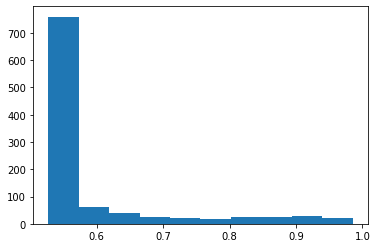

In [105]:
print('worst state: ', targets[fidelities.argmin(),:])
plt.hist(np.squeeze(np.vstack(worst_fidelity)))

implement heisenberg model

In [94]:
basis = [0b100, 0b010, 0b001]

# external field
diag = lambda i : np.diag([(b >> i) & 1 for b in basis])

# coupling
def nondiag(i):
    [[if (a ^ b) >> for b in basis] for a in basis]
            

In [ ]:
def h_generator(batch_size):
    def generate_parametric(n, dv_lambda, name):
        params = tf.get_variable(name, dtype='float64', shape=(batch_size, n), initializer=tf.truncated_normal_initializer)
        params = tf.cast(params, 'complex128')
        places = tf.constant(np.stack([dv_lambda(c) for c in range(n)]), dtype='complex128')
        return tf.tensordot(params, places, axes=[1, 0])
    

    neardiag = lambda i : sp.coo_matrix(
        ([1, 1], ([i, (i + 1) % dim], [(i + 1) % dim, i % dim])), shape=(dim, dim)).toarray()

    diag = lambda i : sp.coo_matrix(([1], ([i], [i])), shape=(dim, dim)).toarray()
    h = generate_parametric(dim - 1, neardiag, 'neardiag') + generate_parametric(dim, diag, 'diag')
    
    return h